In [ ]:
!pip install tavily-python python-dotenv \ langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers

In [1]:
import openai
import base64
import fitz  # PyMuPDF
from openai import OpenAI
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI

In [3]:
from langchain_core.messages import BaseMessage, HumanMessage
from typing_extensions import TypedDict
from typing import Annotated, List
import operator

class BoltState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]
    image: str
    diameter: str
    head_type: str
    length: str

In [12]:
from tavily import TavilyClient
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")
client = TavilyClient(api_key=tavily_api_key)

def get_travily_context(query="engineering technical drawing for bolts labels explanations"):
    response = client.search(query=query, search_depth="advanced")
    return "\n\n".join([res['content'] for res in response.get('results', []) if 'content' in res])

travily_context = get_travily_context()


In [13]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

image_b64 = encode_image_to_base64("102.jpg")


In [24]:
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage

# Prepare LLM
llm = ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"), temperature=0.0)

def agent_ask_property(property_name: str, context: str):
    def fn(state):
        # Compose the prompt
        prompt = (
            f"Context: {context}\n"
            "[An image of a bolt is attached, not shown here.]\n"
            f"Your task: Given the image , what is the {property_name} of the bolt? "
            "Respond with only the value, nothing else."
        )
        resp = llm([HumanMessage(content=prompt)])
        result = resp.content.strip()
        state[property_name] = result
        # Add to message history
        state['messages'].append(AIMessage(content=f"{property_name}: {result}"))
        return state
    return fn


In [20]:
def routing_logic(state):
    if not state.get("diameter"):
        state["next_step"] = "get_diameter"
    elif not state.get("head_type"):
        state["next_step"] = "get_head_type"
    elif not state.get("length"):
        state["next_step"] = "get_length"
    else:
        state["next_step"] = "end"
    return state


In [21]:
from langgraph.graph import StateGraph, END, START

# Build LangGraph workflow
workflow = StateGraph(BoltState)
workflow.add_node("router", routing_logic)
workflow.add_node("get_diameter", agent_ask_property("diameter", travily_context))
workflow.add_node("get_head_type", agent_ask_property("head_type", travily_context))
workflow.add_node("get_length", agent_ask_property("length", travily_context))
# ... (define your nodes above)

# REQUIRED: Set the entry point for the graph
workflow.add_edge(START, "router")

# Then all your previous edges:
workflow.add_edge("router", "get_diameter")
workflow.add_edge("router", "get_head_type")
workflow.add_edge("router", "get_length")
workflow.add_edge("get_diameter", "router")
workflow.add_edge("get_head_type", "router")
workflow.add_edge("get_length", "router")
workflow.add_edge("router", END)

graph = workflow.compile()


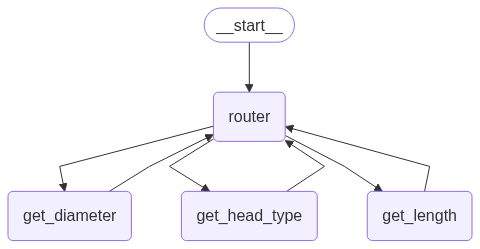

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [ ]:
###aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
def main():
    initial_state = {
        "messages": [],
        "image": image_b64,
        "diameter": "",
        "head_type": "",
        "length": "",
    }
    final_state = graph.invoke(initial_state)
    print("Final extracted bolt info:")
    print(f"  Diameter:   {final_state.get('diameter', '[not found]')}")
    print(f"  Head Type:  {final_state.get('head_type', '[not found]')}")
    print(f"  Length:     {final_state.get('length', '[not found]')}")
    # Optionally, show the full state for debugging
    # print("Full final state:", final_state)

if __name__ == "__main__":
    main()


InvalidUpdateError: At key 'image': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE